In [6]:

!pip install -U langchain-tavily


You should consider upgrading via the 'C:\Users\chris\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from langchain_groq import ChatGroq
from typing import Annotated, Sequence, TypedDict, Literal
import operator
import functools
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import ToolNode

# Set API keys
os.environ["TAVILY_API_KEY"] = ""
os.environ["GROQ_API_KEY"] = ""

# Verify API keys
print(f"TAVILY_API_KEY loaded: {os.getenv('TAVILY_API_KEY') is not None}")
print(f"GROQ_API_KEY loaded: {os.getenv('GROQ_API_KEY') is not None}")

# Use a more capable model that handles tool calling better
llm = ChatGroq(
    model="llama-3.3-70b-versatile",  # More capable model for tool calling
    temperature=0,
    max_retries=2
)

# Create Tavily tool
tavily_tool = TavilySearchResults(max_results=3)  # Reduced results for simplicity

# Create Python REPL tool
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant. Use the provided tools to answer questions."
                " Be precise and follow instructions carefully. If you complete the task,"
                " respond with FINAL ANSWER: [your answer].\n"
                "Available tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

def agent_node(state, agent, name):
    try:
        result = agent.invoke(state)
        if isinstance(result, ToolMessage):
            pass
        else:
            result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        return {
            "messages": [result],
            "sender": name,
        }
    except Exception as e:
        # Handle errors gracefully
        error_msg = AIMessage(content=f"Error in {name}: {str(e)}", name=name)
        return {
            "messages": [error_msg],
            "sender": name,
        }

# Research agent
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="Search for accurate data about UK GDP statistics.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart generator agent
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Create Python code to generate charts using matplotlib.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

# Tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    if not messages:
        return "continue"
    
    last_message = messages[-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

# Build the workflow
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

# Test with a simpler query first
print("Testing with simpler query...")

try:
    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    content="What was the UK's GDP in 2023? Search for this information."
                )
            ],
        },
        {"recursion_limit": 10},  # Reduced limit for testing
    )
    
    for s in events:
        print(s)
        print("----")
        
except Exception as e:
    print(f"Error occurred: {e}")
    print("Trying alternative approach...")
    
    # Fallback: Use the LLM directly without tool calling
    simple_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that provides information about UK GDP."),
        ("human", "{query}")
    ])
    
    simple_chain = simple_prompt | llm
    response = simple_chain.invoke({"query": "What was the UK's GDP over the past 5 years?"})
    print(f"Direct response: {response.content}")

TAVILY_API_KEY loaded: True
GROQ_API_KEY loaded: True
Testing with simpler query...


C:\Users\chris\AppData\Local\Temp\ipykernel_17832\3868435911.py:77: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'a32s9p2fj', 'function': {'arguments': '{"query":"UK GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 350, 'total_tokens': 372, 'completion_time': 0.047299803, 'prompt_time': 0.033486678, 'queue_time': 0.196295453, 'total_time': 0.080786481}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run--10eddc38-052a-4b8c-b496-823f5fd88a7f-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP 2023'}, 'id': 'a32s9p2fj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 350, 'output_tokens': 22, 'total_tokens': 372})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"title": "UK GDP 2024 - Statista", "url": "h

C:\Users\chris\AppData\Local\Temp\ipykernel_17832\3868435911.py:77: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'w6v9vtzy4', 'function': {'arguments': '{"query":"UK GDP statistics 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1086, 'total_tokens': 1109, 'completion_time': 0.035030079, 'prompt_time': 0.087728621, 'queue_time': 0.204026559, 'total_time': 0.1227587}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run--3103d23e-8a13-45a2-8171-66f1260dc6d6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP statistics 2023'}, 'id': 'w6v9vtzy4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1086, 'output_tokens': 23, 'total_tokens': 1109})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"title": "UK GDP gro

C:\Users\chris\AppData\Local\Temp\ipykernel_17832\3868435911.py:77: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [ ]:
import os
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START
from langchain_groq import ChatGroq
from typing import Annotated, Sequence, TypedDict, Literal
import operator
import functools
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langgraph.prebuilt import ToolNode

# Set API keys
os.environ["TAVILY_API_KEY"] = ""
os.environ["GROQ_API_KEY"] = ""

# Verify API keys
print(f"TAVILY_API_KEY loaded: {os.getenv('TAVILY_API_KEY') is not None}")
print(f"GROQ_API_KEY loaded: {os.getenv('GROQ_API_KEY') is not None}")

# Use a more capable model that handles tool calling better
llm = ChatGroq(
    model="llama-3.3-70b-versatile",  # More capable model for tool calling
    temperature=0,
    max_retries=2
)

# Create Tavily tool
tavily_tool = TavilySearchResults(max_results=3)  # Reduced results for simplicity

# Create Python REPL tool
repl = PythonREPL()

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant. Use the provided tools to answer questions."
                " Be precise and follow instructions carefully. If you complete the task,"
                " respond with FINAL ANSWER: [your answer].\n"
                "Available tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

TAVILY_API_KEY loaded: True
GROQ_API_KEY loaded: True


In [78]:

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

def agent_node(state, agent, name):
    try:
        result = agent.invoke(state)
        if isinstance(result, ToolMessage):
            pass
        else:
            result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
        return {
            "messages": [result],
            "sender": name,
        }
    except Exception as e:
        # Handle errors gracefully
        error_msg = AIMessage(content=f"Error in {name}: {str(e)}", name=name)
        return {
            "messages": [error_msg],
            "sender": name,
        }

# Research agent
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="Search for accurate data about UK GDP statistics.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Chart generator agent
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Create Python code to generate charts using matplotlib.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

# Tool node
tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

def router(state) -> Literal["call_tool", "__end__", "continue"]:
    messages = state["messages"]
    if not messages:
        return "continue"
    
    last_message = messages[-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        return "__end__"
    return "continue"

In [79]:

# Build the workflow
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END},
)
workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)
workflow.add_edge(START, "Researcher")
graph = workflow.compile()


In [75]:
# Test with a simpler query first
print("Testing with simpler query...")

try:
    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    content="What was the UK's GDP in 2023? Search for this information."
                )
            ],
        },
        {"recursion_limit": 10},  # Reduced limit for testing
    )
    
    for s in events:
        print(s)
        print("----")
        
except Exception as e:
    print(f"Error occurred: {e}")
    print("Trying alternative approach...")
    
    # Fallback: Use the LLM directly without tool calling
    simple_prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a helpful assistant that provides information about UK GDP."),
        ("human", "{query}")
    ])
    
    simple_chain = simple_prompt | llm
    response = simple_chain.invoke({"query": "What was the UK's GDP over the past 5 years?"})
    print(f"Direct response: {response.content}")

Testing with simpler query...


C:\Users\chris\AppData\Local\Temp\ipykernel_17832\3824646332.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rmgt320db', 'function': {'arguments': '{"query":"UK GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 350, 'total_tokens': 372, 'completion_time': 0.048776631, 'prompt_time': 0.047182959, 'queue_time': 0.198242056, 'total_time': 0.09595959}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run--19cdd7f2-0a85-4931-91dc-87f0e3a2e157-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP 2023'}, 'id': 'rmgt320db', 'type': 'tool_call'}], usage_metadata={'input_tokens': 350, 'output_tokens': 22, 'total_tokens': 372})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"title": "UK GDP 2024 - Statista", "url": "ht

C:\Users\chris\AppData\Local\Temp\ipykernel_17832\3824646332.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'krbb1bj05', 'function': {'arguments': '{"query":"UK GDP statistics 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 1086, 'total_tokens': 1109, 'completion_time': 0.027207272, 'prompt_time': 0.102982141, 'queue_time': 0.202635614, 'total_time': 0.130189413}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run--35e98348-eead-487d-90db-64e57f4b0dba-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP statistics 2023'}, 'id': 'krbb1bj05', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1086, 'output_tokens': 23, 'total_tokens': 1109})], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [ToolMessage(content='[{"title": "UK GDP g

C:\Users\chris\AppData\Local\Temp\ipykernel_17832\3824646332.py:11: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


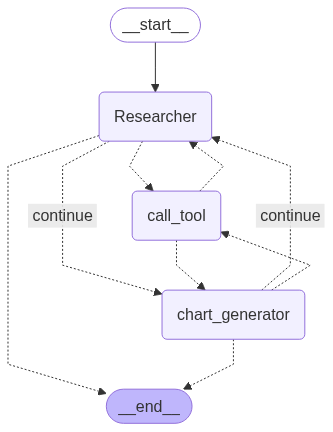

In [76]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass